In [1]:
!pip install cufflinks

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
from itertools import product
import datetime as dt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import warnings
from pickle import dump
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

In [3]:
retail = pd.read_excel('online_retail_II.xlsx')
retail.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [5]:
retail.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

In [6]:
retail = retail[retail['Customer ID'].notnull()]

In [7]:
retail.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [8]:
retail.loc[:, 'Date'] = retail.apply(lambda x: dt.datetime(x.InvoiceDate.year,
                                                           x.InvoiceDate.month,
                                                           x.InvoiceDate.day), axis=1)

In [9]:
dt.datetime.now()

datetime.datetime(2024, 7, 26, 23, 11, 45, 741689)

In [10]:
retail.Date.max()

Timestamp('2010-12-09 00:00:00')

In [11]:
current_date = retail.Date.max() + dt.timedelta(1)
retail['Total Price'] = retail.apply(lambda x: x['Quantity'] * x['Price'], axis=1)

In [12]:
rfm_df = retail.groupby('Customer ID').agg({
    'Date' : (lambda x: (current_date - x.max()).days), # R
    'Invoice' : 'count', # F
    'Total Price' : 'sum' # M
})

In [13]:
rfm_df.head()

,Date,Invoice,Total Price
Customer ID,,,
12346.0,67,46,-64.68
12347.0,3,71,1323.32
12348.0,74,20,222.16
12349.0,43,107,2646.99
12351.0,11,21,300.93


In [14]:
np.sum(retail[retail['Customer ID'] == 12346.0]['Quantity'] * retail[retail['Customer ID'] == 12346.0]['Price'])

-64.68

In [15]:
current_date - retail[retail['Customer ID'] == 12347.0]['Date'].max()

Timedelta('3 days 00:00:00')

In [16]:
rfm_df.rename({
    'Date' : 'Recency',
    'Invoice' : 'Frequency',
    'Total Price' : 'Monetary'
}, axis=1, inplace=True)

In [17]:
rfm_list = ['R', 'F', 'M']
[rfm_list[i] for i in range(len(rfm_list)) if 'Recency'.find(rfm_list[i]) != -1]

['R']

In [18]:
def bucketing_normalization(df:pd.DataFrame, feature:str, n_buckets:4, bucket_labels:range):
    rfm_list = ['R', 'F', 'M']
    colum_name = [rfm_list[i] for i in range(len(rfm_list)) if feature.find(rfm_list[i]) != -1][0]
    df[colum_name] = pd.qcut(x=df[feature], q=n_buckets, labels=bucket_labels)
    return df

In [19]:
rfm_df = bucketing_normalization(rfm_df, 'Recency', 4, range(4, 0, -1))
rfm_df = bucketing_normalization(rfm_df, 'Frequency', 4, range(1, 5))
rfm_df = bucketing_normalization(rfm_df, 'Monetary', 4, range(1, 5))

In [20]:
rfm_df.head()

,Recency,Frequency,Monetary,R,F,M
Customer ID,,,,,,
12346.0,67,46,-64.68,2,3,1
12347.0,3,71,1323.32,4,3,3
12348.0,74,20,222.16,2,2,1
12349.0,43,107,2646.99,3,4,4
12351.0,11,21,300.93,4,2,2


In [21]:
X = rfm_df[['R', 'F', 'M']]

In [22]:
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300)
kmeans.fit(X)

KMeans(n_clusters=5)

In [23]:
rfm_df['KMeans y_pred'] = kmeans.labels_

In [24]:
np.unique(rfm_df['KMeans y_pred'], return_counts=True)

(array([0, 1, 2, 3, 4]), array([1129,  730, 1069, 1152,  303], dtype=int64))

In [25]:
rfm_df.head()

,Recency,Frequency,Monetary,R,F,M,KMeans y_pred
Customer ID,,,,,,,
12346.0,67,46,-64.68,2,3,1,2
12347.0,3,71,1323.32,4,3,3,0
12348.0,74,20,222.16,2,2,1,3
12349.0,43,107,2646.99,3,4,4,0
12351.0,11,21,300.93,4,2,2,1


In [26]:
def rfm_rel_labels(model_y_pred:str):
    rfm_list = ['Recency', 'Frequency', 'Monetary']
    fig, axs = plt.subplots(3, 1, figsize=(12, 12))
    items = product(rfm_list, axs)
    for i, item in enumerate(items):
        # (i == 0) --> state 1: Recency and axis 0
        # (i == 4) --> state 5: Frequency and axis 1
        # (i == 8) --> state 9: Monetary and axis 2
        if (i == 0) or (i == 4) or (i == 8):
            item[1].scatter(x=[f'Cluster {clusterNum + 1}' if clusterNum != -1 else 'Outlier Cluster' for clusterNum in 
                              rfm_df.sort_values([model_y_pred])[model_y_pred].astype('int')],
                       y=rfm_df.sort_values([model_y_pred])[item[0]], c=rfm_df.sort_values([model_y_pred])[model_y_pred])
            item[1].set_title(model_y_pred, size=14)
            item[1].set_xlabel('The Cluster Number')
            item[1].set_ylabel(item[0])
            plt.tight_layout()
            if model_y_pred == 'DBSCAN y_pred':
                item[1].tick_params(axis='x', labelrotation=90)

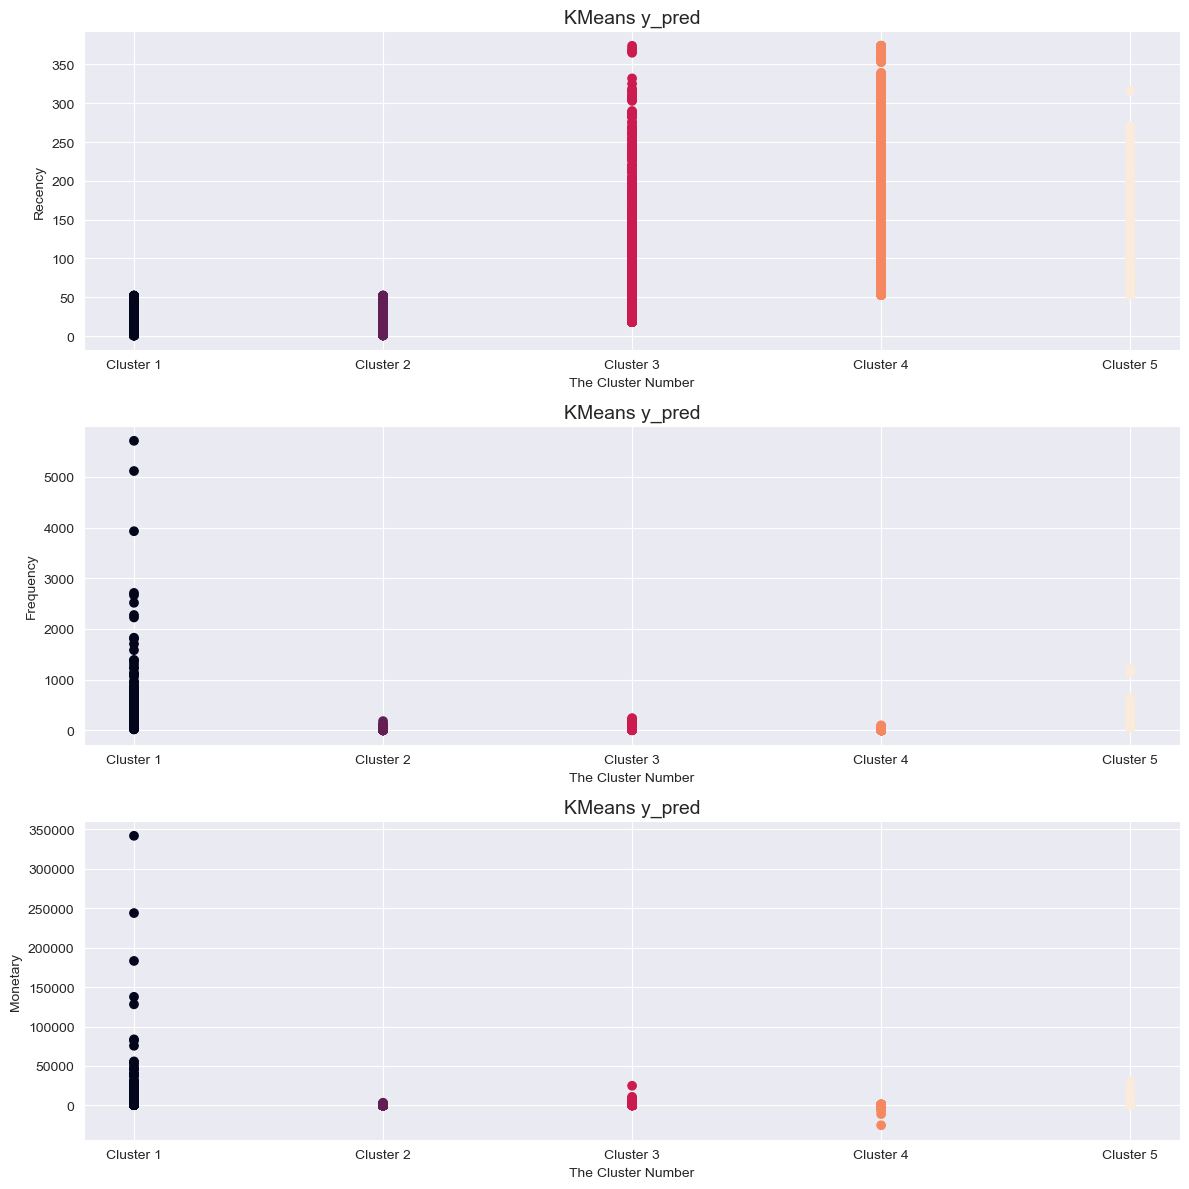

In [27]:
rfm_rel_labels('KMeans y_pred')

In [28]:
class RFMDetails():
    """
    If the clustering models categorize some samples into cluster -1 which indicates Noises,
    You must set the start parameter with -1 to methods work very well, and
    If not, set the start parameter with 0. So, you can set the start
    parameter with 0 or -1.
    """
    
    def __init__(self, model_y_pred:str, with_average:bool=True, start:int=0):
        self.model_y_pred = model_y_pred
        self.with_average = with_average
        self.start = start
        self.rfm_mean = list()
        self.get_mean_of_rfm()
        self.rfm_mean_df = self.get_rfm_mean_df()
        
    
    def get_mean_of_rfm(self):
        if (self.start == 0) or (self.start == -1):
            for i in range(self.start, len(rfm_df[self.model_y_pred].unique()) + self.start):
                if self.with_average == True: 
                    print('The RFM dataframe Info:')
                    print(rfm_df[['Recency', 'Frequency', 'Monetary']].describe().T[['count', 'mean', 'std', 'min', 'max']].T,
                                                                                                                           '\n')
                    print(f'The Cluster {i + 1} Info:')
                    print(rfm_df[rfm_df[self.model_y_pred] == i][['Recency', 'Frequency', 'Monetary']].describe().T[['count',
                                                                                                                  'mean',
                                                                                                                  'std',
                                                                                                                  'min',
                                                                                                                  'max']].T,
                                                                                                                  '\n')
                    access = 1
                    if access == 1:
                        self.rfm_mean.append(rfm_df[rfm_df[self.model_y_pred] == i][['Recency', 'Frequency', 'Monetary']].mean().values)
                        access = 0
                else:
                    access = 1
                    if access == 1:
                        self.rfm_mean.append(rfm_df[rfm_df[self.model_y_pred] == i][['Recency', 'Frequency', 'Monetary']].mean().values)
                        access = 0
        else:
            print('You must set the start parameter with 0 or -1. for more information, please read docstring :)')
               
            
    def get_rfm_mean_df(self):
        s1 = [f"Cluster {num + 1}" if num != -1 else 'Outlier Cluster' for num in sorted(rfm_df[self.model_y_pred].unique())]
        s2 = ['mean']
        multi_index = pd.MultiIndex.from_product([s1, s2])
        rfm_mean_df = pd.DataFrame(data=self.rfm_mean, columns=['Recency', 'Frequency', 'Monetary'], index=multi_index)
        return rfm_mean_df

In [29]:
rfm_details = RFMDetails('KMeans y_pred', with_average=True, start=0)
rfm_details

The RFM dataframe Info:
           Recency    Frequency       Monetary
count  4383.000000  4383.000000    4383.000000
mean     91.395848    95.262149    1904.679118
std      98.177019   204.903882    8519.369281
min       1.000000     1.000000  -25111.090000
max     374.000000  5710.000000  341776.730000 

The Cluster 1 Info:
           Recency    Frequency       Monetary
count  1129.000000  1129.000000    1129.000000
mean     15.057573   242.859167    5295.889369
std      12.809130   351.896161   16134.285181
min       1.000000    19.000000     313.280000
max      52.000000  5710.000000  341776.730000 

The RFM dataframe Info:
           Recency    Frequency       Monetary
count  4383.000000  4383.000000    4383.000000
mean     91.395848    95.262149    1904.679118
std      98.177019   204.903882    8519.369281
min       1.000000     1.000000  -25111.090000
max     374.000000  5710.000000  341776.730000 

The Cluster 2 Info:
          Recency   Frequency     Monetary
count  730.000000

In [30]:
rfm_details.rfm_mean

[array([  15.05757307,  242.8591674 , 5295.88936935]),
 array([ 23.46986301,  26.26712329, 405.16738356]),
 array([ 90.10757717,  53.85313377, 956.16900094]),
 array([207.91319444,  15.50694444, 153.71106858]),
 array([ 101.03630363,  160.85148515, 2885.00816172])]

In [31]:
rfm_mean_df = rfm_details.rfm_mean_df
rfm_mean_df

,,Recency,Frequency,Monetary
Cluster 1,mean,15.057573,242.859167,5295.889369
Cluster 2,mean,23.469863,26.267123,405.167384
Cluster 3,mean,90.107577,53.853134,956.169001
Cluster 4,mean,207.913194,15.506944,153.711069
Cluster 5,mean,101.036304,160.851485,2885.008162


In [32]:
def stacked_bar_mean(model_y_pred):
    cluster_names = [item[0] for item in rfm_mean_df.index.tolist()]
    r_trace = go.Bar(
        x = cluster_names,
        y = rfm_mean_df['Recency'],
        name = 'Recency'
        )

    f_trace = go.Bar(
        x = cluster_names,
        y = rfm_mean_df['Frequency'],
        name = 'Frequency'
        )

    m_trace = go.Bar(
        x = cluster_names,
        y = rfm_mean_df['Monetary'],
        name = 'Monetary'
        )

    layout = go.Layout(title='The RFM Mean for each Cluster',
                       barmode='stack')

    fig = go.Figure(data=[r_trace, f_trace, m_trace], layout=layout)
    if model_y_pred == 'DBSCAN y_pred':
        fig.update_layout(yaxis_visible=False, xaxis_tickangle=-90)
        fig.show()
    else:
        fig.update_layout(yaxis_visible=False)
        fig.show()

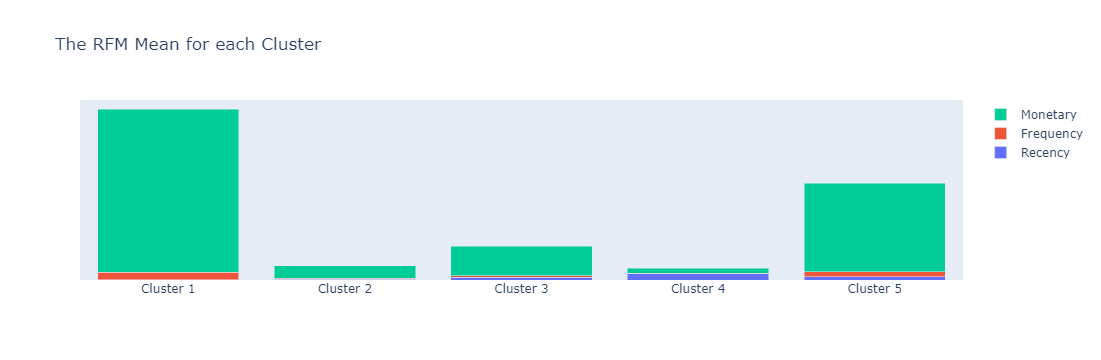

In [33]:
stacked_bar_mean('KMeans y_pred')

In [34]:
kmeans.inertia_

3894.0639097201415

In [35]:
elbow = {}
for k in range(1, 51):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    elbow[k] = kmeans.inertia_

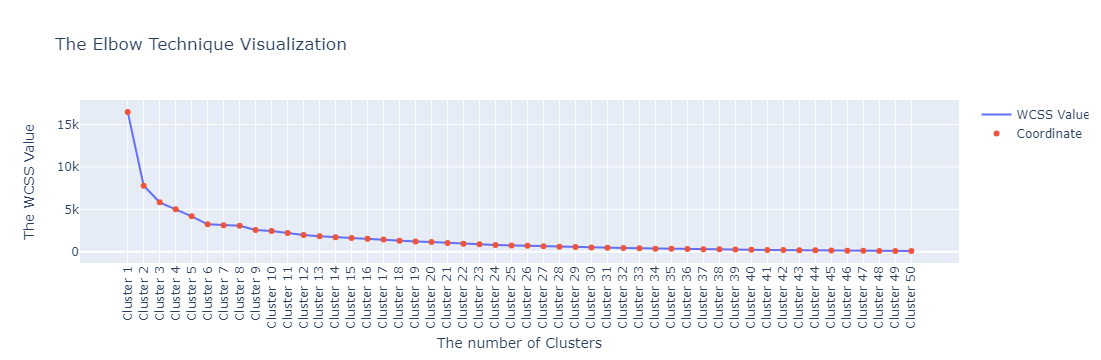

In [36]:
point_plot_trace = go.Scatter(
    x = [f'Cluster {num}' for num in sorted(list(elbow.keys()))],
    y = list(elbow.values()),
    mode = 'markers',
    name = 'Coordinate'
)

line_trace = go.Scatter(
    x = [f'Cluster {num}' for num in sorted(list(elbow.keys()))],
    y = list(elbow.values()),
    mode = 'lines',
    name = 'WCSS Value'
)

layout = go.Layout(
    title = 'The Elbow Technique Visualization',
    xaxis = dict(title='The number of Clusters'),
    yaxis = dict(title='The WCSS Value')
)

point_plot = go.Figure(data=[line_trace, point_plot_trace], layout=layout)
point_plot.update_layout(xaxis_tickangle=-90)
point_plot.show()

In [37]:
kmeans = KMeans(n_clusters=50, random_state=0)
kmeans.fit(X)

KMeans(n_clusters=50, random_state=0)

In [38]:
np.unique(kmeans.labels_, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 array([163, 223, 415, 433, 122, 169, 159,  72,  73,  81, 102, 172, 129,
        184, 136,  72,  95, 120, 148,  63,  97,  67,  86,  77,  67,  52,
         53,  54,  50,  60,  47,  45,  48,  43,  27,  21,  44,  26,  47,
         21,  28,  21,  24,  29,  18,  23,  17,  25,  12,  23], dtype=int64))

In [39]:
rfm_df['KMeans y_pred'] = kmeans.labels_

In [40]:
print(silhouette_score(X=X, labels=rfm_df['KMeans y_pred']))

0.969574368900631


In [41]:
dbscan = DBSCAN(eps=.5, min_samples=5)
dbscan.fit(X)

DBSCAN()

In [42]:
rfm_df['DBSCAN y_pred'] =dbscan.labels_

In [43]:
np.unique(rfm_df['DBSCAN y_pred'], return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
        50, 51, 52, 53, 54, 55, 56, 57], dtype=int64),
 array([  7,  21, 136,  43, 223,  72,  31, 148, 172,  86, 129, 163, 415,
         97,  18,  53,  47,  67,  54,  81,  85, 433,  60, 122, 159, 169,
         77,  63,  20,  12,  17, 120,  17,  61, 184,  14,  50,  95,  24,
          6,  18,  45,   8,  52,  47,   8,  21,  48,  19,  72,  67,  13,
         17,  26,   7,  23,  17,  12,  12], dtype=int64))

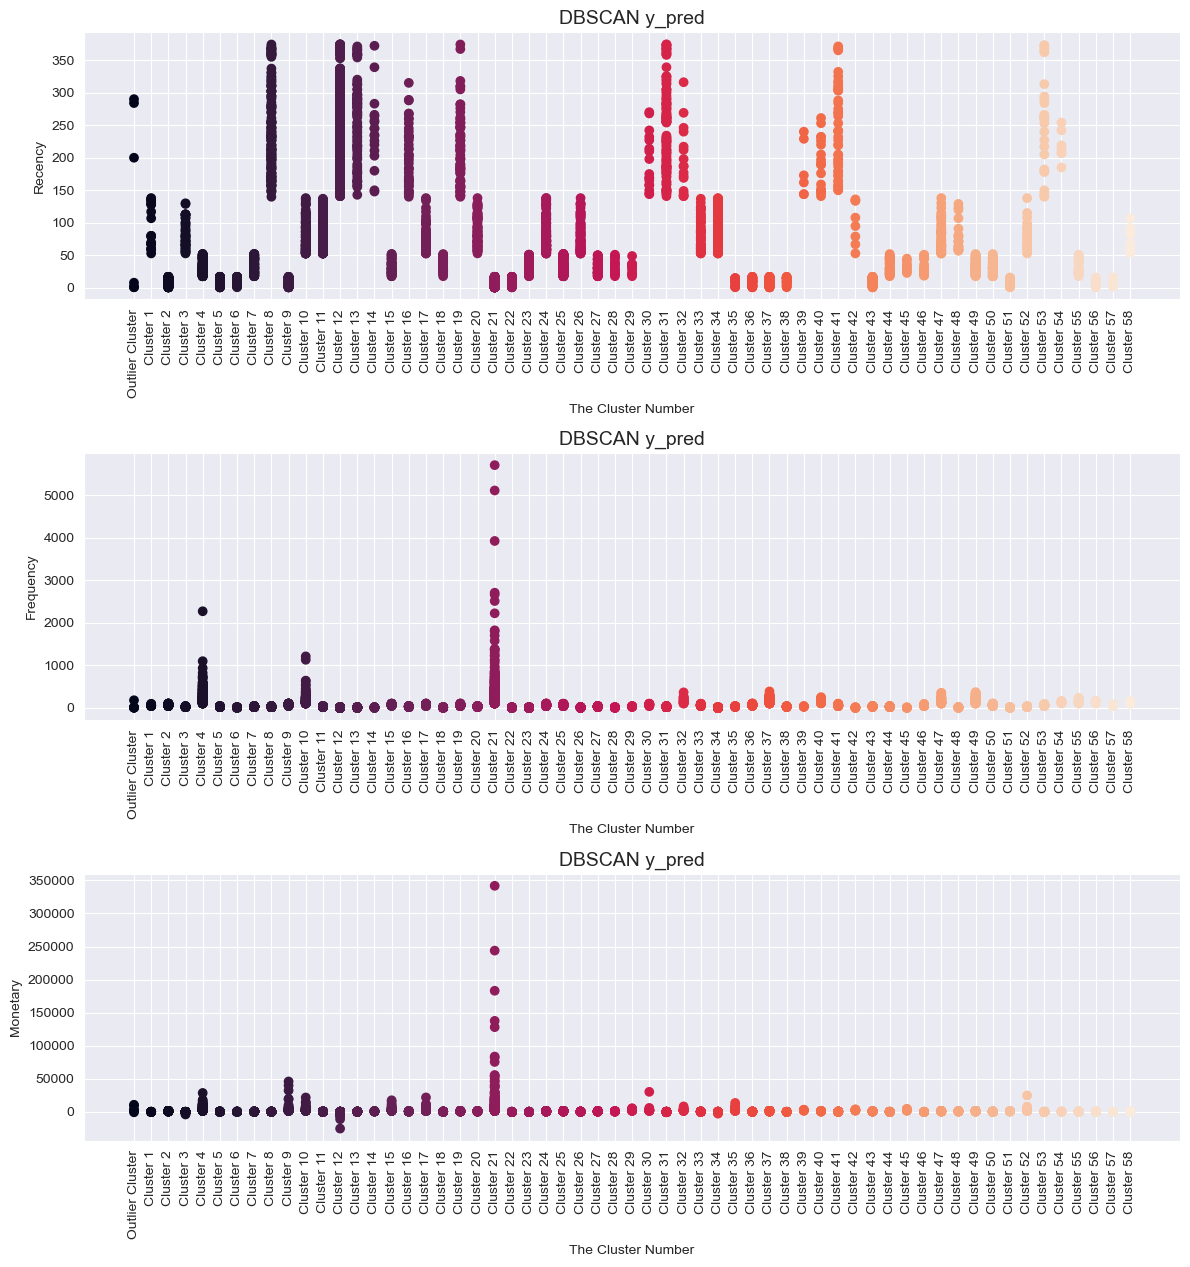

In [44]:
rfm_rel_labels('DBSCAN y_pred')

In [45]:
rfm_details = RFMDetails('DBSCAN y_pred', with_average=False, start=-1)
rfm_details

In [46]:
rfm_mean_df = rfm_details.rfm_mean_df
rfm_mean_df

,,Recency,Frequency,Monetary
Outlier Cluster,mean,112.285714,34.142857,4199.392857
Cluster 1,mean,96.809524,60.380952,207.013810
Cluster 2,mean,8.522059,71.492647,1146.821471
Cluster 3,mean,82.255814,28.139535,19.794884
Cluster 4,mean,30.748879,268.116592,4141.010771
Cluster 5,mean,10.180556,30.069444,468.629583
Cluster 6,mean,10.419355,11.741935,386.645161
Cluster 7,mean,34.290541,28.648649,445.171554
Cluster 8,mean,241.395349,28.529070,436.962733
Cluster 9,mean,8.069767,80.104651,4547.749791


In [47]:
rfm_df[rfm_df["DBSCAN y_pred"] == -1][['Recency', 'Frequency', 'Monetary']].mean()

Recency       112.285714
Frequency      34.142857
Monetary     4199.392857
dtype: float64

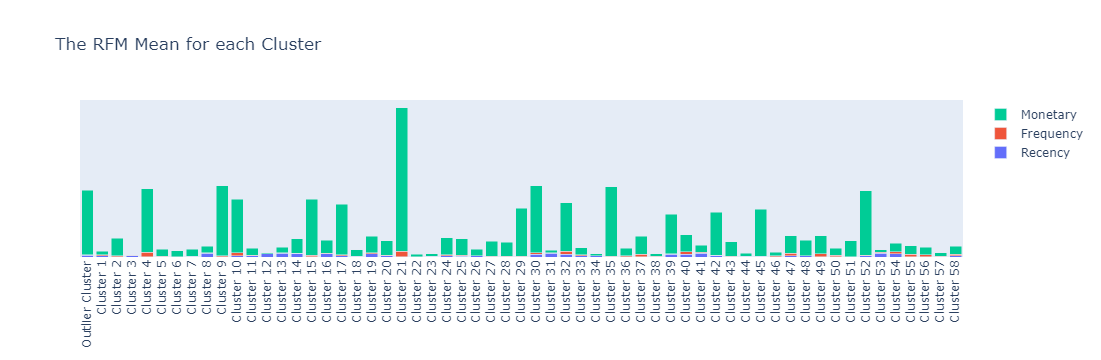

In [48]:
stacked_bar_mean('DBSCAN y_pred')

In [49]:
print(silhouette_score(X=X, labels=rfm_df['DBSCAN y_pred']))

0.997453590282271


In [50]:
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
        50, 51, 52, 53, 54, 55, 56, 57], dtype=int64),
 array([  7,  21, 136,  43, 223,  72,  31, 148, 172,  86, 129, 163, 415,
         97,  18,  53,  47,  67,  54,  81,  85, 433,  60, 122, 159, 169,
         77,  63,  20,  12,  17, 120,  17,  61, 184,  14,  50,  95,  24,
          6,  18,  45,   8,  52,  47,   8,  21,  48,  19,  72,  67,  13,
         17,  26,   7,  23,  17,  12,  12], dtype=int64))

In [51]:
dbscan = DBSCAN(eps=.8, min_samples=3)
dbscan.fit(X)

DBSCAN(eps=0.8, min_samples=3)

In [52]:
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
        50, 51, 52, 53, 54, 55, 56, 57, 58, 59], dtype=int64),
 array([  1,  21, 136,  43, 223,  72,  31, 148, 172,  86, 129, 163, 415,
         97,  18,  53,  47,  67,  54,  81,  85, 433,  60, 122, 159, 169,
         77,  63,  20,  12,  17, 120,  17,  61, 184,  14,  50,  95,  24,
          6,  18,  45,   8,  52,  47,   8,  21,  48,  19,  72,  67,  13,
         17,  26,   7,  23,  17,   3,  12,   3,  12], dtype=int64))

In [53]:
rfm_df['DBSCAN y_pred'] =dbscan.labels_

In [54]:
print(silhouette_score(X=X, labels=rfm_df['DBSCAN y_pred']))

0.999771845767739
